In [3]:
!pip install lifetimes

import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data


In [16]:
# Load the data
data = pd.read_excel('/content/online_retail_II.xlsx')

In [18]:
# Preprocess the data and Handle missing values
data.dropna(inplace=True)

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [19]:
# Print the column names
print(data.columns)

# Reset the index
data = data.reset_index()

# Calculate TotalSum
data['TotalSum'] = data['Quantity'] * data['Price']  # Assuming 'Quantity' and 'Price' are your relevant columns

# Create a summary dataframe for CLV calculations
summary = summary_data_from_transaction_data(data, 'Customer ID', 'InvoiceDate', monetary_value_col='TotalSum')

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


             frequency  recency      T  monetary_value  predicted_purchases  \
Customer ID                                                                   
18102.0           45.0    373.0  373.0     7544.233111             0.106849   
14646.0           49.0    363.0  372.0     4860.041020             0.116349   
14156.0           98.0    367.0  373.0     1858.303571             0.230242   
14911.0          143.0    373.0  373.0      957.638322             0.335291   
13694.0           54.0    362.0  370.0     2326.713519             0.128635   
17511.0           27.0    370.0  372.0     2987.109630             0.065034   
15061.0           41.0    371.0  373.0     1924.097561             0.097514   
16684.0           21.0    353.0  367.0     3545.764286             0.051567   
16754.0           20.0    269.0  276.0     2608.209000             0.062725   
13089.0           80.0    369.0  372.0      693.252625             0.188837   

                       clv  
Customer ID           

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

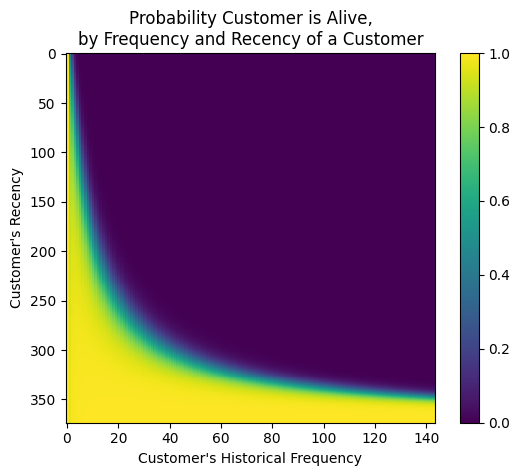

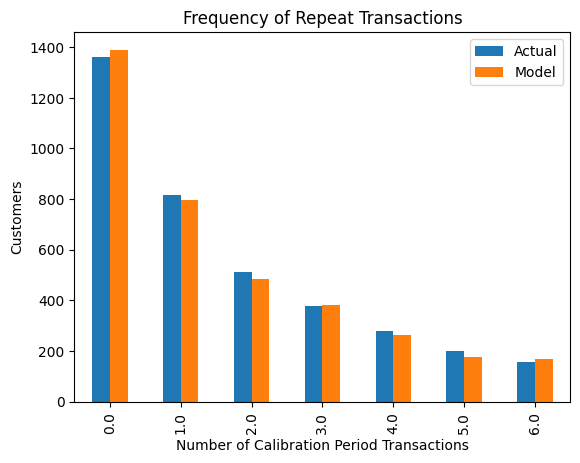

In [20]:
# Fit a BG/NBD model to estimate customer lifetime
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Visualize frequency/recency matrix
plot_frequency_recency_matrix(bgf)

# Predict future purchases for each customer
t = 1  # Predict purchases in the next 1 period (adjust as needed)
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])

# Preprocess the data to remove non-positive monetary values
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value'] > 0]

# Fit a Gamma-Gamma model to estimate customer lifetime value
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

# Calculate CLV for each customer
summary['clv'] = ggf.customer_lifetime_value(bgf,
                                           summary['frequency'],
                                           summary['recency'],
                                           summary['T'],
                                           summary['monetary_value'],
                                           time=12,  # Predict CLV over the next 12 periods (adjust as needed)
                                           discount_rate=0.01)  # Adjust discount rate as needed

# Print top 10 customers with highest CLV
print(summary.sort_values(by='clv', ascending=False).head(10))

# Visualize probability of customers being alive
plot_probability_alive_matrix(bgf)

# Visualize number of transactions over time
plot_period_transactions(bgf)
